In [1]:
import matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec
from datetime import timedelta
import json, os,csv
from sys import argv

plt.style.use("seaborn-poster")

def plot_results(df, int_vars:list, ax_arg=None, total=False,log=False, Reff=None,
                 plotpath=False,legend=False,summary=False,forecast_days=28):
    if ax_arg is None:
        if Reff is None:
            fig, ax = plt.subplots(figsize=(12,9))
        else:
            #fig, (ax,ax2) = plt.subplots(figsize=(12,9),nrows=2,gridspec_kw={'height_ratios': [3, 1.5]}, sharex=True)
            fig = plt.figure(constrained_layout=True)
            gs = fig.add_gridspec(3, 1)
            ax = fig.add_subplot(gs[:2, 0])
            
            ax2 = fig.add_subplot(gs[2, 0],sharex=ax)
    elif Reff is not None:
        ax2 = ax_arg[1]
        ax = ax_arg[0]
    else:
        ax = ax_arg
    if summary:
        #Using summary files
  
        for var in int_vars:
            df.columns = df.columns.astype('datetime64[ns]')
            ax.fill_between(df.columns.values[:-forecast_days], df.loc[(var,'lower')].values[:-forecast_days], df.loc[(var,'upper')].values[:-forecast_days], alpha=0.4,color='C0', label='nowcast')
            ax.fill_between(df.columns.values[:-forecast_days], df.loc[(var,'bottom')].values[:-forecast_days], df.loc[(var,'top')].values[:-forecast_days], alpha=0.2,color='C0')
            ax.fill_between(df.columns.values[:-forecast_days], df.loc[(var,'lower10')].values[:-forecast_days], df.loc[(var,'upper10')].values[:-forecast_days], alpha=0.2,color='C0')
            ax.fill_between(df.columns.values[:-forecast_days], df.loc[(var,'lower15')].values[:-forecast_days], df.loc[(var,'upper15')].values[:-forecast_days], alpha=0.2,color='C0')
            ax.fill_between(df.columns.values[:-forecast_days], df.loc[(var,'lower20')].values[:-forecast_days], df.loc[(var,'upper20')].values[:-forecast_days], alpha=0.2,color='C0')
            
            #forecast color
            ax.fill_between(df.columns.values[-forecast_days:], df.loc[(var,'lower')].values[-forecast_days:], df.loc[(var,'upper')].values[-forecast_days:], alpha=0.4,color='C1', label ='forecast')
            ax.fill_between(df.columns.values[-forecast_days:], df.loc[(var,'bottom')].values[-forecast_days:], df.loc[(var,'top')].values[-forecast_days:], alpha=0.2,color='C1')
            ax.fill_between(df.columns.values[-forecast_days:], df.loc[(var,'lower10')].values[-forecast_days:], df.loc[(var,'upper10')].values[-forecast_days:], alpha=0.2,color='C1')
            ax.fill_between(df.columns.values[-forecast_days:], df.loc[(var,'lower15')].values[-forecast_days:], df.loc[(var,'upper15')].values[-forecast_days:], alpha=0.2,color='C1')
            ax.fill_between(df.columns.values[-forecast_days:], df.loc[(var,'lower20')].values[-forecast_days:], df.loc[(var,'upper20')].values[-forecast_days:], alpha=0.2,color='C1')
            if plotpath:
                print("Cannot plot path using summary files")
                raise KeyError
            else:
                ax.plot(df.columns.values[:-forecast_days], df.loc[(var,'median')].values[:-forecast_days], label=var, color='C0')
                ax.plot(df.columns.values[-forecast_days:], df.loc[(var,'median')].values[-forecast_days:], label=var, color='C1')

            
            ax.set_xticks([df.columns.values[-1*forecast_days]],minor=True)
            ax.xaxis.grid(which='minor', linestyle='--',alpha=0.6, color='black')

    else:
        #using the raw simulation files
        if total:
            for n in range(df.loc['symp_obs'].shape[0]):
                df.loc[('total_inci_obs',n),:] = df.loc[(int_vars[0],n)] + df.loc[(int_vars[1],n)]
            int_vars=['total_inci_obs']
        for var in int_vars:
            df.columns = df.columns.astype('datetime64[ns]')
            #ax.fill_between(df.columns, df.transpose()[var].quantile(0.05,axis=1), df.transpose()[var].quantile(0.95,axis=1), alpha=0.2,color='C0')
            ax.fill_between(df.columns, df.transpose()[var].quantile(0.05,axis=1), df.transpose()[var].quantile(0.95,axis=1), alpha=0.1,color='C0')

            if plotpath:
                n = 0
                good_sims = df.loc[~df.isna().any(axis=1)].index.get_level_values("sim")
                while True:
                    
                    ax.plot(df.columns, df.loc[(var,good_sims[n])], label=var,alpha=0.8,color='C0', linewidth=0.5)
                    n +=1
                    if n>15:
                        break
            else:
                ax.plot(df.columns, df.transpose()[var].quantile(0.5,axis=1), label=var)

            ax.set_xticks([df.columns.values[-1*forecast_days]],minor=True)
            ax.xaxis.grid(b=True,which='minor', linestyle='--',alpha=0.6, color='black')
    
    if len(int_vars)>1:
        ax.legend()
    ax.set_ylim(bottom=0)
    #ax.set_ylabel("Cases")
    if log:
        ax.set_yscale("log")
    if legend:
        fig.legend()
    
    if Reff is not None:

        ax2.plot(df.columns.values[:-forecast_days], Reff.loc[df.columns].mean(axis=1).values[:-forecast_days])
        ax2.fill_between(df.columns.values[:-forecast_days], 
        Reff.loc[df.columns].quantile(0.25,axis=1).values[:-forecast_days],Reff.loc[df.columns].quantile(0.75,axis=1).values[:-forecast_days],alpha=0.4 ,color='C0')
        ax2.fill_between(df.columns.values[:-forecast_days], 
        Reff.loc[df.columns].quantile(0.05,axis=1).values[:-forecast_days],Reff.loc[df.columns].quantile(0.95,axis=1).values[:-forecast_days],alpha=0.4,color='C0' )

        #forecast
        ax2.plot(df.columns.values[-forecast_days:], Reff.loc[df.columns].mean(axis=1).values[-forecast_days:], color='C1')
        ax2.fill_between(df.columns.values[-forecast_days:], 
        Reff.loc[df.columns].quantile(0.25,axis=1).values[-forecast_days:],Reff.loc[df.columns].quantile(0.75,axis=1).values[-forecast_days:],alpha=0.4 ,color='C1')
        ax2.fill_between(df.columns.values[-forecast_days:], 
        Reff.loc[df.columns].quantile(0.05,axis=1).values[-forecast_days:],Reff.loc[df.columns].quantile(0.95,axis=1).values[-forecast_days:],alpha=0.4,color='C1') 

        ax2.set_yticks([1],minor=True,)
        ax2.set_yticks([0,2],minor=False)
        ax2.set_yticklabels([0,2],minor=False)
        ax2.yaxis.grid(which='minor',linestyle='--',color='black',linewidth=2)
        #ax2.set_ylabel("Reff")
        #ax2.tick_params('x',rotation=45)
        plt.setp(ax.get_xticklabels(), visible=False)
        #ax2.set_xlabel("Date")
        
        ax2.set_xticks([df.columns.values[-1*forecast_days]],minor=True)
        ax2.xaxis.grid(which='minor', linestyle='--',alpha=0.6, color='black')
        
        months = matplotlib.dates.MonthLocator()
        year_month = matplotlib.dates.DateFormatter('%Y-%m')
        
        
        ax.xaxis.set_major_locator(months)
        ax.xaxis.set_major_formatter(year_month)


    else:
        #ax.set_xlabel("Date")
        ax.tick_params('x',rotation=90)
    if ax_arg is None:
        if Reff is None:
            return fig,ax
        else:
            return fig,ax,ax2
    elif Reff is not None:
        return ax,ax2
    else:
        return ax

def read_in_Reff(forecast_R=None,R_I=None,file_date = "2020-04-01"):
        """
        Read in Reff csv from Price et al 2020. Originals are in RDS, are converted to csv in R script
        """
        import pandas as pd
        import os
        
        dir_path = os.getcwd()
        
        datapath = os.path.join(dir_path,'../data/')
        #df= pd.read_csv(datapath+'R_eff_2020_04_23.csv', parse_dates=['date'])
        #df = df.loc[df.date>= self.start_date]
        
        #df = df.set_index(['state','date'])
        
        
        if forecast_R is not None:
            df_forecast = pd.read_hdf(datapath+'soc_mob_R'+file_date+'.h5',
            key='Reff')
            
            if R_I is not None:
                mean = df_forecast.loc[df_forecast.type=='R_I','mean'].values[0]
                std = df_forecast.loc[df_forecast.type=='R_I','std'].values[0]
                R_I = np.random.gamma(mean**2/std**2, std**2/mean, size=100)

            #R_L here 
   

            df_forecast = df_forecast.loc[df_forecast.type==forecast_R]
            df_forecast.set_index(['state','date'],inplace=True)
            df = df_forecast
            #df = pd.concat([
            #            df.drop(['type','date_onset','confidence',
            #                 'mean_window','prob_control',
            #                'sd_window'],axis=1),
            #            df_forecast.drop(['type'],axis=1)
            #                ])
            #df = df.reset_index().drop_duplicates(['state','date'],keep='last')
            #df = df.set_index(['state','date'])
                
        return df
    
def read_in_cases(cases_file_date=None):
    """
    Read in NNDSS case file data
        
    """
    import pandas as pd
    from datetime import timedelta
    import glob

    if cases_file_date is None:
        import glob, os

        list_of_files = glob.glob("../data/"+'COVID-19 UoM*.xlsx') 
        path = max(list_of_files, key=os.path.getctime)
        print("Using file "+path)
    else:
        path = "../data/"+"COVID-19 UoM "+cases_file_date+"*.xlsx"

    for file in glob.glob(path):
        df = pd.read_excel(file,
                   parse_dates=['SPECIMEN_DATE','NOTIFICATION_DATE','NOTIFICATION_RECEIVE_DATE','TRUE_ONSET_DATE'],
                   dtype= {'PLACE_OF_ACQUISITION':str})
    if len(glob.glob(path))!=1:
        print("There are %i files with the same date" %len(glob.glob(path)))

        if len(glob.glob(path)) >1:
            print("Using an arbritary file")

    print(path)
    
    df.PLACE_OF_ACQUISITION.fillna('00038888',inplace=True) #Fill blanks with simply unknown

    df['date_inferred'] = df.TRUE_ONSET_DATE
    #missing_cases = df.groupby('STATE').TRUE_ONSET_DATE.agg(lambda x: sum(x.isna()))
    #print("Unknown Symptom onset dates")
    #display(missing_cases)
    df.loc[df.TRUE_ONSET_DATE.isna(),'date_inferred'] = df.loc[df.TRUE_ONSET_DATE.isna()].NOTIFICATION_DATE - timedelta(days=5)
    df.loc[df.date_inferred.isna(),'date_inferred'] = df.loc[df.date_inferred.isna()].NOTIFICATION_RECEIVE_DATE - timedelta(days=6)

    df['imported'] = df.PLACE_OF_ACQUISITION.apply(lambda x: 1 if x[-4:]=='8888' and x != '00038888' else 0)
    df['local'] = 1 - df.imported
    
    
    df_cases_state_time = df.groupby(['STATE','date_inferred'])[['imported','local']].sum()
    df_cases_state_time.reset_index(inplace=True)
    
    df_cases_state_time['cum_imported'] = df_cases_state_time.groupby('STATE').imported.transform(pd.Series.cumsum)
    df_cases_state_time['cum_local'] = df_cases_state_time.groupby('STATE').local.transform(pd.Series.cumsum)

    return df_cases_state_time

def calculate_scores(observations,forecasts):
    """
    Given an array of forecasts (rows = samples, columns = dates), 
    generate the crps metric
    """
    import properscoring as ps

    crps_score = ps.crps_ensemble(
        observations,
        forecasts,
        axis=0
    ) 
    #brier_score = ps.brier_score(
    #    observations,
    #    forecasts
    #)
    return crps_score#, brier_score


../data/COVID-19 UoM 03May*.xlsx
../data/COVID-19 UoM 01Jul*.xlsx
../data/COVID-19 UoM 15Jul*.xlsx
forecast up to: 2020-07-30 00:00:00
Number of sims not rejected for state NSW is 13401
Number of unique Reff paths not rejected is 2000 
Number of sims not rejected for state VIC is 20000
Number of unique Reff paths not rejected is 2000 
../data/COVID-19 UoM 05Aug*.xlsx
../data/COVID-19 UoM 19Aug*.xlsx
Bad dates include:
    STATE date_inferred  imported  local  cum_imported  cum_local
420   VIC    2002-07-17         0      1             0          1
forecast up to: 2020-09-03 00:00:00
Number of sims not rejected for state NSW is 19540
Number of unique Reff paths not rejected is 2000 
Number of sims not rejected for state VIC is 20000
Number of unique Reff paths not rejected is 2000 
../data/COVID-19 UoM 02Sep*.xlsx
../data/COVID-19 UoM 16Sep*.xlsx
forecast up to: 2020-10-01 00:00:00
Collation and quantiles not made
../results/quantilesR_L2020-03-01sim_20000days_214.parquet


KeyError: "The following 'id_vars' are not present in the DataFrame: ['date', 'state', 'type']"

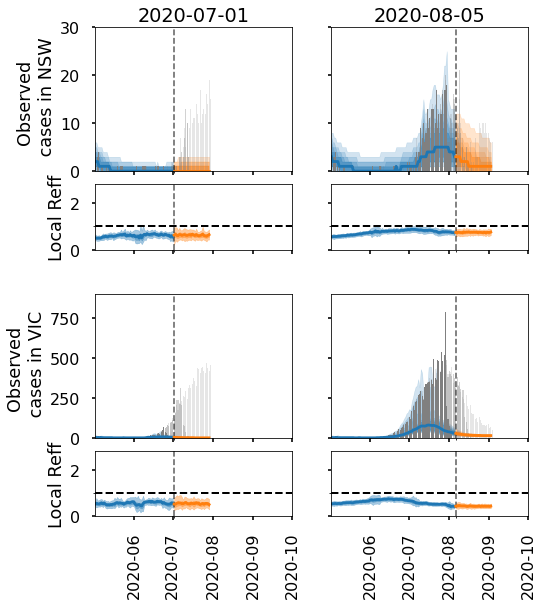

In [3]:

# Dates to provide results for:
# 1. July 1st 151 days (incursion of VIC)
# 2. Early Aug 5th 186 days (peak of VIC)
# 3. Early Sept 2nd? 214 days (end of VIC)
# Sims are 8000
days_dict = {
    '2020-07-01':151,
    '2020-08-05':186,
    '2020-09-02':214,
}

date='2020-07-01'
dates = ['2020-07-01','2020-08-05','2020-09-02']

all=False
half=False
forecast_type = 'R_L' #default None

df_future = read_in_cases(cases_file_date="03May") #None grabs latest file

if all:
    states = ['QLD','SA','TAS','WA','ACT','NT']
    if half:
        states = states[:3]
    else:
        states = states[3:]
    ## Local cases
    fig = plt.figure(figsize=(12,12))
    gs = fig.add_gridspec(len(states),len(dates))
else:
    states = ['NSW','VIC']
    ## Local cases
    fig = plt.figure(figsize=(12,9))
    gs = fig.add_gridspec(len(states),len(dates))

for j,date in enumerate(dates):
    
    
    data_date = pd.to_datetime(date)
    
    df_cases_state_time = read_in_cases(cases_file_date=data_date.strftime("%d%b")) 
    df_14days = read_in_cases(cases_file_date=(data_date+pd.Timedelta(days=14)).strftime("%d%b"))
    Reff = read_in_Reff( forecast_R=forecast_type, file_date= date)

    
    n_sims = 20000
    start_date = '2020-03-01'
    days = days_dict[date]
    #check if any dates are incorrect
    try:
        num_bad_dates = df_cases_state_time.loc[
                        (df_cases_state_time.date_inferred<='2020-01-01')].shape[0]
        assert num_bad_dates==0, "Data contains {} bad dates".format(num_bad_dates)
    except AssertionError:
        print("Bad dates include:")
        print(df_cases_state_time.loc[
                        (df_cases_state_time.date_inferred<='2020-01-01')])
        df_cases_state_time.loc[df_cases_state_time.date_inferred=='2002-07-17','date_inferred'] = pd.to_datetime('2020-07-17')


    end_date = pd.to_datetime(start_date,format='%Y-%m-%d') + timedelta(days=days)

    print("forecast up to: {}".format(end_date))

    try:
        df_results = pd.read_parquet("../results/quantiles"+forecast_type+start_date+"sim_"+str(
        n_sims)+"days_"+str(days)+".parquet")
    except FileNotFoundError:
        print("Collation and quantiles not made")
        print("../results/quantiles"+forecast_type+start_date+"sim_"+str(
        n_sims)+"days_"+str(days)+".parquet")

    df_results = pd.melt(df_results, id_vars=['state','date','type'],
                     value_vars=['bottom','lower','median','upper','top',
                     'lower10','upper10','lower15','upper15',
                     'lower20','upper20', 
                     ],
                    )

    df_results = pd.pivot_table(df_results, 
                            index=['state','type','variable'],
                            columns='date',
                            values='value')

    with open("../results/good_sims"+str(n_sims)+"days_"+str(days)+".json",'r') as file:
        good_sims = json.load(file)

    os.makedirs("../plots/retro/",exist_ok=True)


    plot_start = pd.to_datetime("2020-05-02")#pd.to_datetime(data_date) - pd.to_timedelta(60,unit="D")
    dates_plot = [d.strftime("%Y-%m-%d") for d in pd.date_range(start = plot_start, end=data_date+pd.Timedelta(days=28))]
    for i,state in enumerate(states):

        print("Number of sims not rejected for state " +state +" is %i"
              % len(good_sims[state]) )
        Reff_used = [r%2000 for r in good_sims[state]]
        print("Number of unique Reff paths not rejected is %i " 
              % len(set(Reff_used) ))

        ##plots
        gs0 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[i,j])
        ax = fig.add_subplot(gs0[:2,0])
        ax2 = fig.add_subplot(gs0[2,0], sharex=ax)

        for k,df in enumerate((df_cases_state_time, df_14days, df_future)):
            dfplot = df.loc[
                (df.STATE==state) 
                & (df.date_inferred >=plot_start) 
                & (df.date_inferred <=end_date)]
            ax.bar(dfplot.date_inferred,dfplot.local, label='Actual',color='grey', alpha=1/(k+1)**1.5)

        R_plot = [r%2000 for r in good_sims[state]]
        ax,ax2= plot_results(df_results.loc[state, dates_plot], ['total_inci_obs'],
        ax_arg = (ax,ax2),summary=True, Reff=Reff.loc[state,R_plot],
        forecast_days=28)
        
        if state=='NSW':
            ax.set_ylim((0,30))
        elif state=='VIC':
            ax.set_ylim((0,900))
        else:
            ax.set_ylim((0,5))
        
        #ax.set_ylim(top=70)
        if j==0:
            ax.set_ylabel("Observed \n cases in "+state)
            ax2.set_ylabel("Local Reff")
        else:
            ax.set_yticklabels([])
            ax2.set_yticklabels([])
        if i==0:
            ax.set_title(date)

        if i!=len(states)-1:
            ax2.set_xticklabels([])
            #ax.set_xticklabels([])
        else:
            #ax.set_xticklabels([])
            ax2.tick_params(axis='x', rotation=90)
    

        #set constant time windows in each plot
        ax.set_xlim((pd.to_datetime('2020-05-02'),pd.to_datetime('2020-10-01')))
        ax2.set_xlim((pd.to_datetime('2020-05-02'),pd.to_datetime('2020-10-01')))
        ax2.set_ylim((0,2.8))

plt.tight_layout()

if all:
    if half:
        plt.savefig("../plots/retro/QLD_states_alldates_local_"+str(n_sims)+'.png',dpi=300)
    else:
        plt.savefig("../plots/retro/WA_states_alldates_local_"+str(n_sims)+'.png',dpi=300)
else:
    plt.savefig("../plots/retro/bigstates_alldates_local_"+str(n_sims)+'.png',dpi=300)

plt.show()

In [ ]:

## Local cases, spaghetti plot
if all:
    fig = plt.figure(figsize=(12,18))
    gs = fig.add_gridspec(4,2)
else:
    ## Local cases
    fig = plt.figure(figsize=(12,6))
    gs = fig.add_gridspec(1,2)

plot_start = pd.to_datetime(data_date) - pd.to_timedelta(60,unit="D")
dates_plot = pd.date_range(start = plot_start, periods=88)
for i,state in enumerate(states):
    
    df_raw = pd.read_parquet("results/"+state+start_date+"sim_"+forecast_type+str(
    n_sims)+"days_"+str(days)+".parquet", 
                             columns= [d.strftime("%Y-%m-%d") for d in dates_plot] )
    

    Reff_used = [r%2000 for r in good_sims[state]]
    
    ##plots
    gs0 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[i])
    ax = fig.add_subplot(gs0[:,0])
    #ax2 = fig.add_subplot(gs0[2,0], sharex=ax)
    
    for j,df in enumerate((df_cases_state_time, df_14days, df_future)):
        dfplot = df.loc[
            (df.STATE==state) 
            & (df.date_inferred >=plot_start) 
            & (df.date_inferred <=end_date)]
        
        ax.bar(dfplot.date_inferred,dfplot.local, label='Actual',color='grey', alpha=1/(j+1)**1.5)
    ylim = ax.get_ylim()
    R_plot = [r%2000 for r in good_sims[state]]
    ax= plot_results(df_raw, ['total_inci_obs'],ax_arg =ax,summary=False,
    plotpath=True,forecast_days=28)
    
    #get forecast dates
    for_start = pd.to_datetime(data_date)
    for_end = end_date
    for_dates = pd.date_range(start=for_start,periods=28,freq='D')
    #select the right data
    df_obs = df_future.loc[
        (df_future.STATE==state) 
        & (df_future.date_inferred >=for_start) 
            & (df_future.date_inferred <for_end)
    ]
    #forecast scores
    df_obs = df_obs.set_index(['date_inferred'])
    df_obs = df_obs.sort_index()
    df_obs = df_obs.reindex(for_dates, fill_value=0)
    crps_scores = calculate_scores(
        df_obs.local.values,
        df_raw.loc[
            'total_inci_obs',
            [d.strftime("%Y-%m-%d") for d in for_dates]]
        )
    str_output = [str(state), data_date]
    str_output.extend(crps_scores)
    if all:
        path = "./analysis/retro_all_scores.csv"
    else:
        path = "./analysis/retro_big_scores.csv" 
    with open(path, 'a') as file:
        writer = csv.writer(file)
        writer.writerow(str_output)
    if state=='NSW':
        ax.set_ylim(ylim)
    elif state=='VIC':
        ax.set_ylim(ylim)
    if i%2==0:
        ax.set_ylabel("Observed \n local cases")
    ax.set_title(state)
    if i< len(states)-2:
        ax.set_xticklabels([])
        ax.set_xlabel('')

    ax.set_xticks([df_raw.columns.values[-1*28]],minor=True)
    ax.xaxis.grid(which='minor', linestyle='--',alpha=0.6, color='black')
plt.tight_layout()
if all:
    plt.savefig("figs/retro/"+plot_start.strftime("%Y-%m-%d")+"spagh"+str(
        n_sims)+"days_"+str(days)+'.png',dpi=300)
else:
    plt.savefig("figs/retro/bigstates"+plot_start.strftime("%Y-%m-%d")+"spagh"+str(
        n_sims)+"days_"+str(days)+'.png',dpi=300)